In [5]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_excel('для_кластеризации.xls')


In [8]:
y = df['target']
X = df.drop(columns = 'target')

In [ ]:
X.head()

,age,educ,work_exp,interest,coffee,boss_educ,passport,green,floor,children,climate,offhour,dist,salary,heigh,lunch
0,50,4,27,8,1.3,1,0,2,3,2,0,0,10.6,1,176,226
1,30,3,10,0,0.0,6,1,2,3,0,0,0,11.5,0,186,226
2,43,3,22,7,1.9,6,1,1,5,0,3,0,12.8,1,166,238
3,58,3,31,7,2.0,4,0,3,3,1,1,0,15.2,1,180,216
4,40,3,23,7,0.0,6,1,3,2,0,0,0,16.1,1,180,286


####Отбор признаков

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select = 5)

rfe.fit(X, y)
rfe.ranking_


array([ 7,  8,  9,  2,  1,  4,  1, 11,  6,  5,  1,  1,  3,  1, 10, 12])

In [ ]:

X = X.drop(columns = ['age',
           'educ', 'work_exp', 'interest',
           'boss_educ', 'green', 'floor',
           'children', 'dist', 'heigh', 'lunch'])

####Выбор количества кластеров

#####Дендрограмма

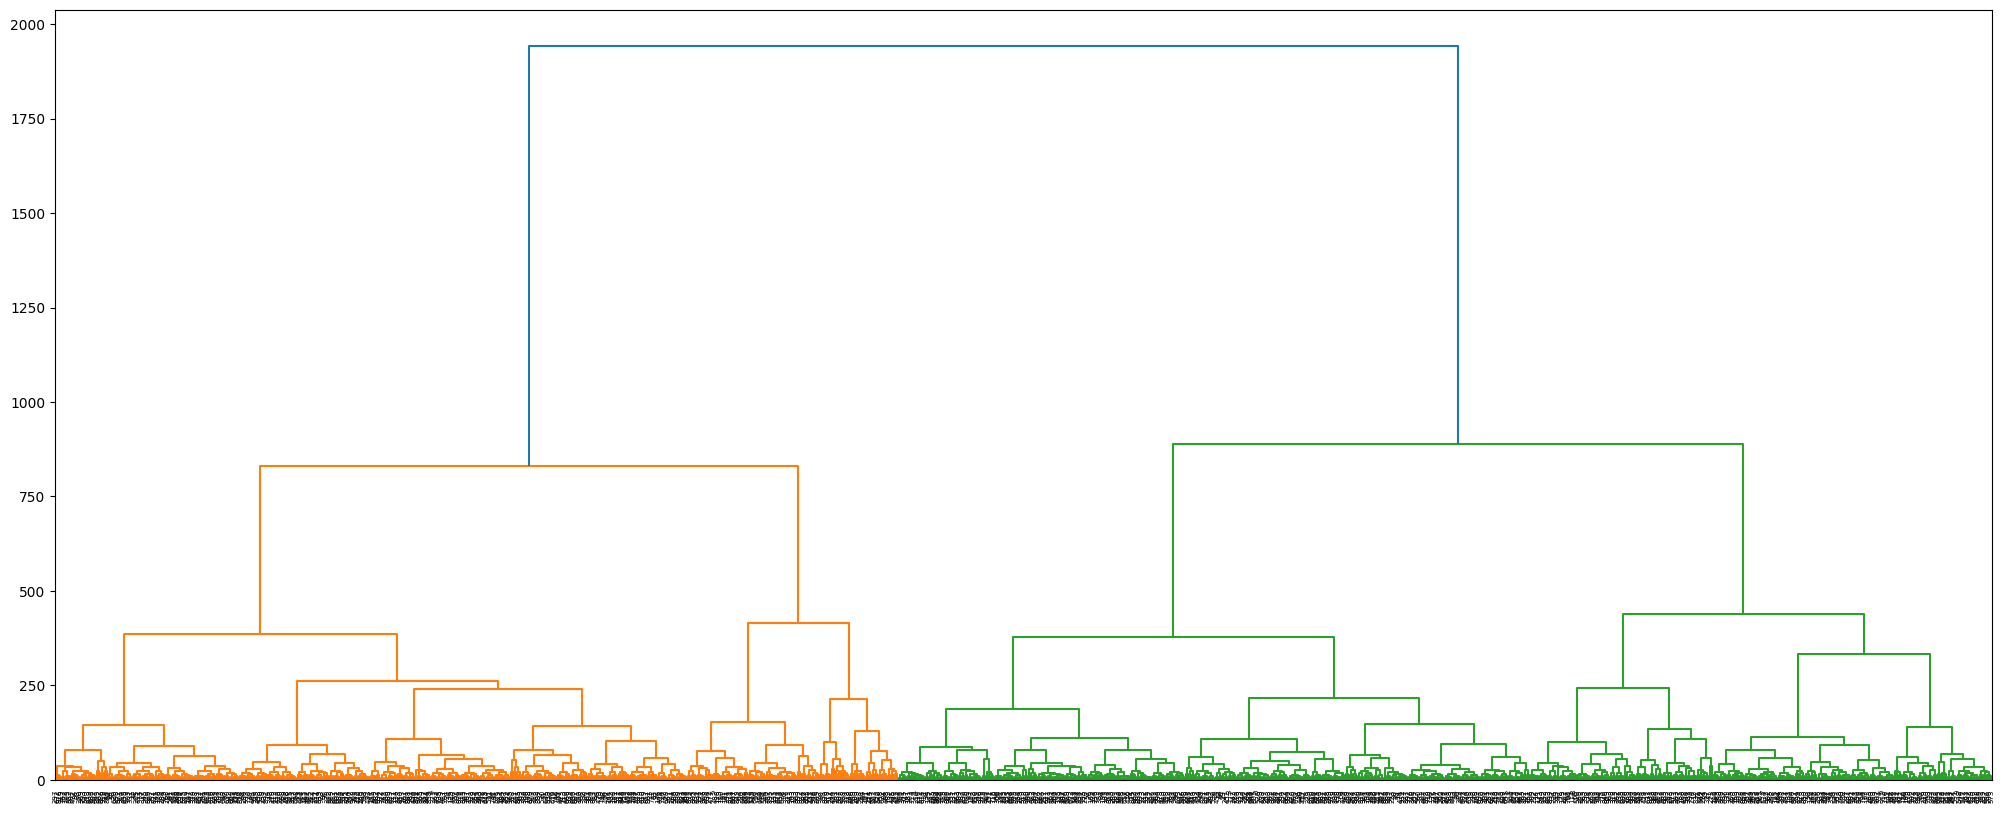

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(df, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)


по дендрограмме наиболее оптимальным количеством кластеров оказывается от 2 до 4, т.к. эти варианты наиболее стабильны.

#####Метод локтя

Text(0, 0.5, '$J(C_k)$')

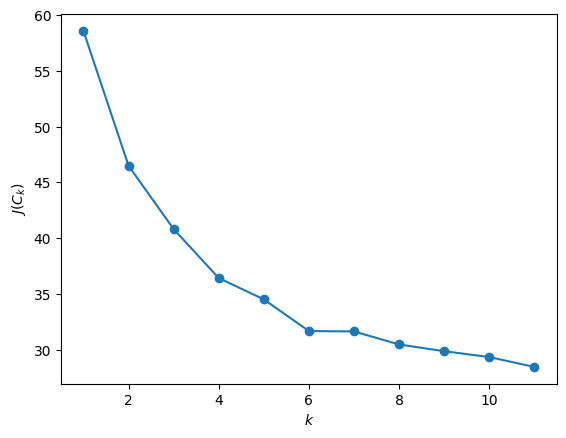

In [ ]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=11).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 12), inertia, marker='o');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

по методу локтя деление на 3 или 4 кластера является оптимальным

#####Силуэт

Среднее значение силуэта для 2 кластеров: 0.33


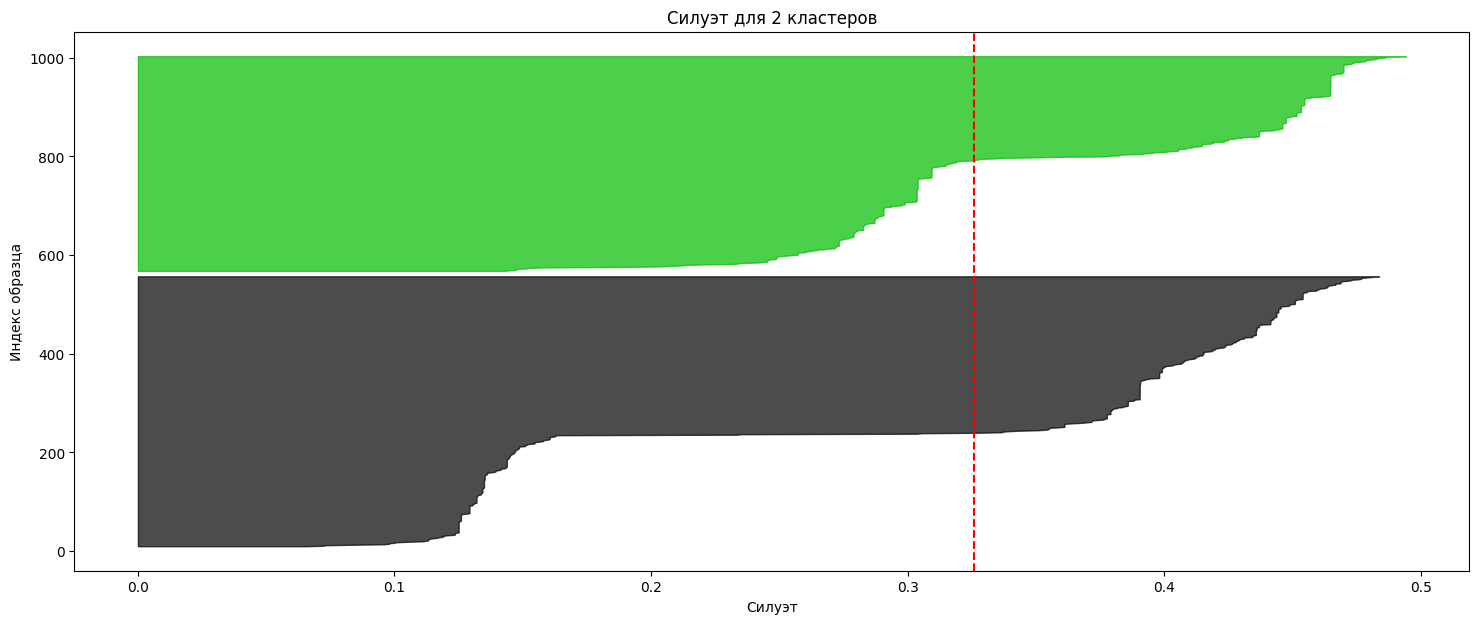

Среднее значение силуэта для 3 кластеров: 0.32


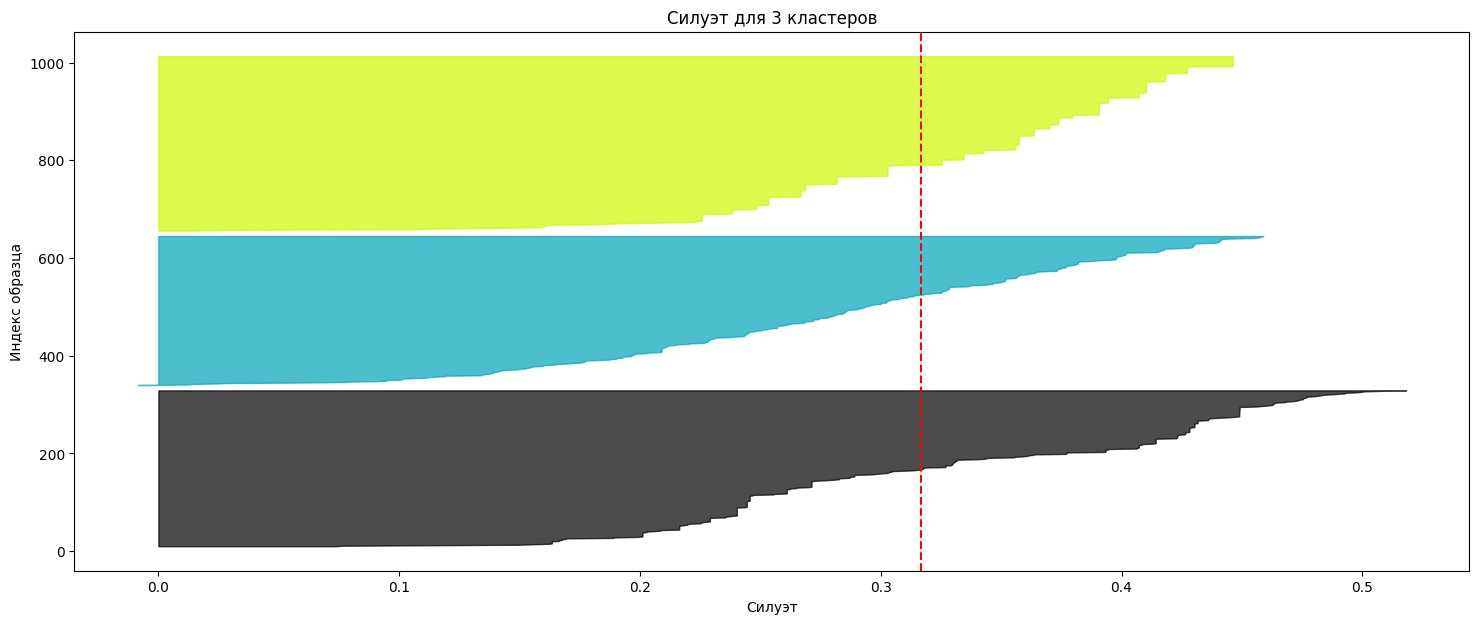

Среднее значение силуэта для 4 кластеров: 0.32


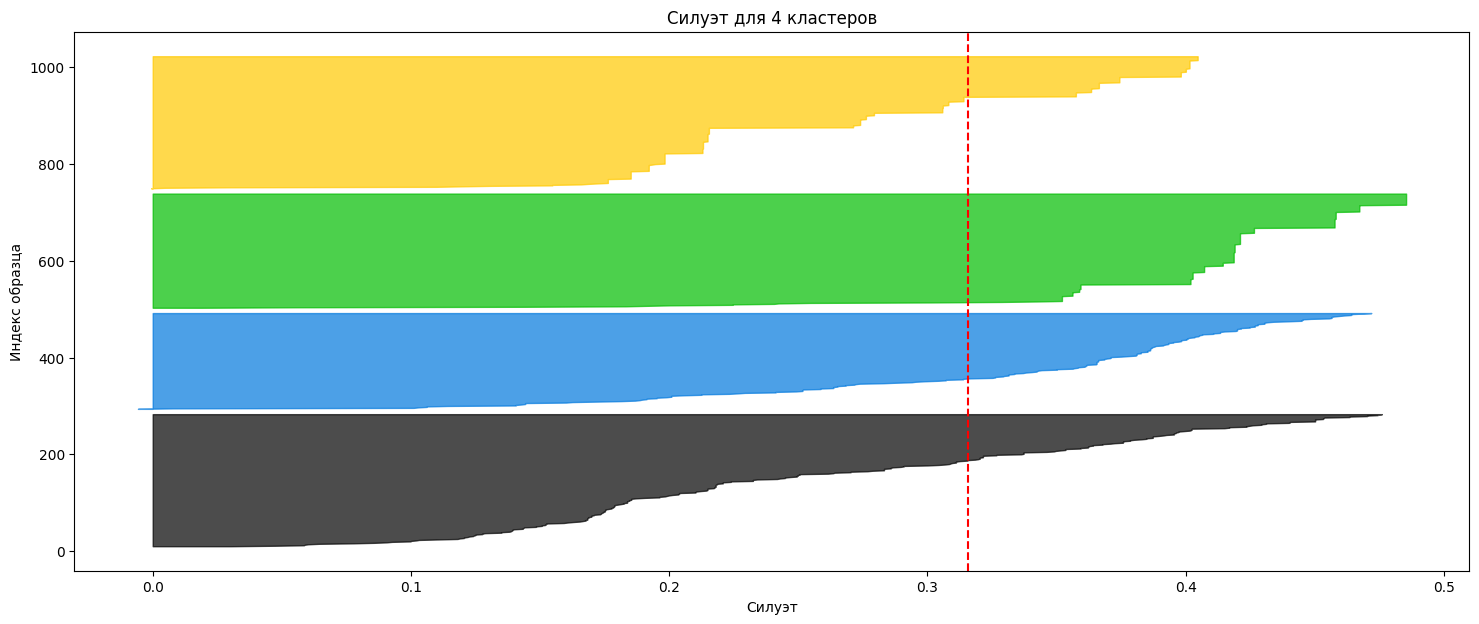

In [ ]:
from matplotlib import cm
from sklearn.metrics import silhouette_score, silhouette_samples



for n_clusters in range (2,5):
  clusterer = KMeans(n_clusters = n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X)

  silhouette_avg = silhouette_score(X, cluster_labels)
  print(f"Среднее значение силуэта для {n_clusters} кластеров:", round(silhouette_avg,2))

  sample_silhouette_values = silhouette_samples(X, cluster_labels)
  fig, (ax1) = plt.subplots(1, 1)
  fig.set_size_inches(18, 7)

  y_lower = 10
  for i in range(0, n_clusters):
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
      y_lower = y_upper + 10


  ax1.set_title(f"Силуэт для {n_clusters} кластеров")
  ax1.set_xlabel("Силуэт")
  ax1.set_ylabel("Индекс образца")
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")  # Добавляем линию среднего значения силуэта
  plt.show()

нужно выбирать количество кластеров с максимальным средним силуэтом.

в данном случае он практически не отличается для 2-4 кластеров.

#####Средние значения признаков

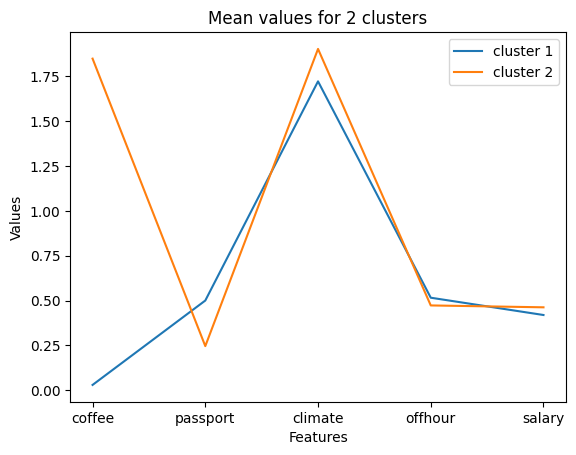

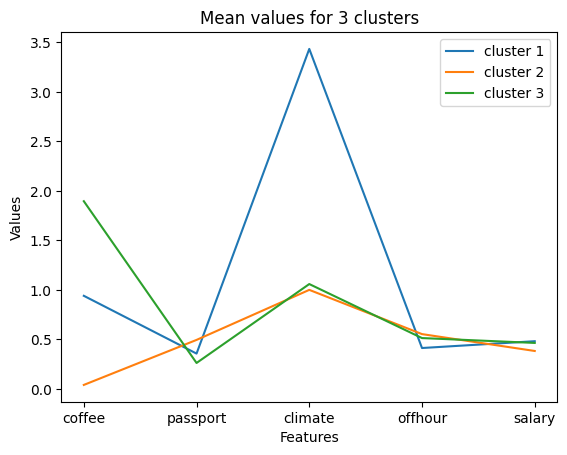

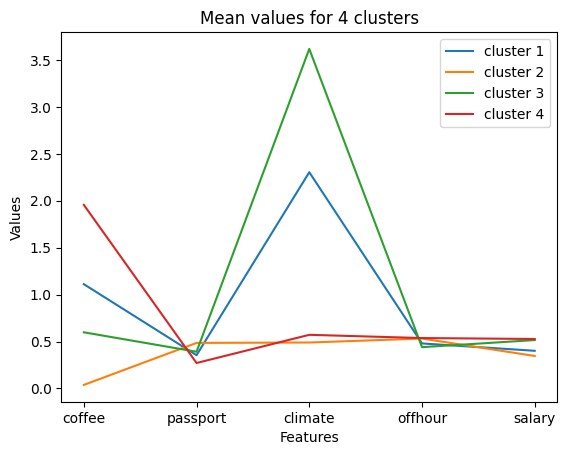

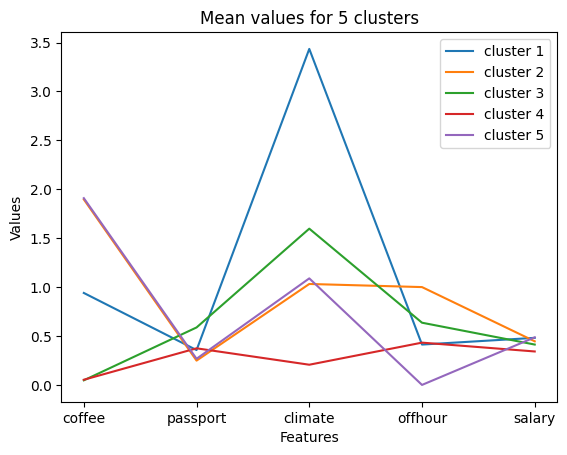

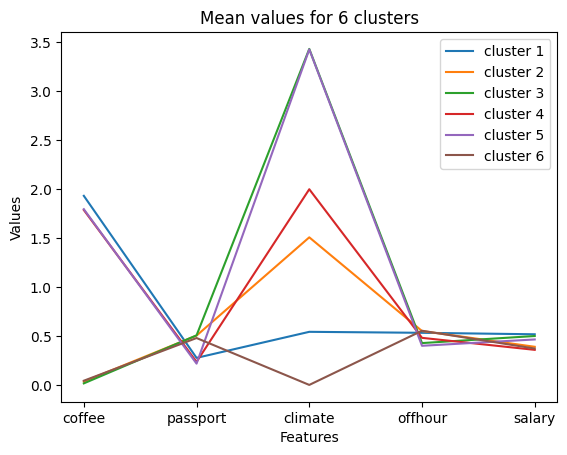

In [ ]:
#посмотрим на средние значения признаков при разном количестве
# кластеров, чем больше они отличаются, тем лучше

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


for n_clusters in range (2,7):
  km = KMeans(n_clusters = n_clusters)
  km.fit(X)
  km.cluster_centers_
  for i in range(0, n_clusters):
    plt.plot(X.columns, km.cluster_centers_[i], label = f'cluster {i+1}')

  plt.title(f'Mean values for {n_clusters} clusters')
  plt.xlabel('Features')
  plt.ylabel('Values')
  plt.legend()
  plt.show()


исходя из графиков средних значений признаков, оптимальное количество кластеров - 3. начиная с 4х кластеров, средние значения дублируют друг друга, то есть некоторые кластеры практически не отличаются друг от друга

####Анализ модели

In [ ]:
#сделаем модель с выбранным количеством кластеров, добавим метки
# наблюдений в исходный датасет

km = KMeans(n_clusters = 3)
df['cluster'] = km.fit_predict(X)

In [ ]:
#посчитаем средние значения таргета в кластерах

np.random.seed(0)
cluster1 = df[(df['cluster']==0)]
cluster2 = df[(df['cluster']==1)]
cluster3 = df[(df['cluster']==2)]


cl1_mean = cluster1['target'].mean()
cl2_mean = cluster2['target'].mean()
cl3_mean = cluster3['target'].mean()


print(cl1_mean, cl2_mean, cl3_mean)

0.08098591549295775 0.4309133489461358 0.3956043956043956


значения таргета в первом и третьем кластере довольно близки, а вот второй кластер явно отличается. в целом классификация более или менее успешная.

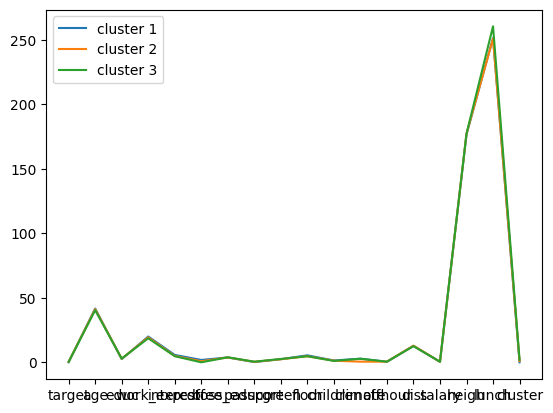

In [ ]:
cl1_total_mean = cluster1[cluster1.columns].mean()
cl2_total_mean = cluster2[cluster2.columns].mean()
cl3_total_mean = cluster3[cluster3.columns].mean()
plt.plot(cluster1.columns, cl1_total_mean, label = 'cluster 1')
plt.plot(cluster1.columns, cl2_total_mean, label = 'cluster 2')
plt.plot(cluster1.columns, cl3_total_mean, label = 'cluster 3')

plt.legend()
plt.show()

кластеры вообще мало чем отличаются друг от друга, но значения таргета у них разные. при обучении таргет был исключен